In [1]:
from google.colab import drive
from PIL import Image, ImageOps
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision, AUC

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_paths = [
    '/content/drive/My Drive/bloodcells_dataset/basophil',
    '/content/drive/My Drive/bloodcells_dataset/erythroblast',
    '/content/drive/My Drive/bloodcells_dataset/ig',
    '/content/drive/My Drive/bloodcells_dataset/lymphocyte',
    '/content/drive/My Drive/bloodcells_dataset/platelet',
    '/content/drive/My Drive/bloodcells_dataset/monocyte',
    '/content/drive/My Drive/bloodcells_dataset/neutrophil',
    '/content/drive/My Drive/bloodcells_dataset/eosinophil'
]


In [ ]:
def load_images_from_folders(folders):
    images_data = []
    labels = []
    inconsistent_images = 0  # Counter for images with inconsistent dimensions
    for folder_index, folder in enumerate(folders):
        print(f"Processing {folder}...")
        try:
            file_list = os.listdir(folder)
        except FileNotFoundError:
            print(f"Folder not found: {folder}")
            continue

        for i, filename in enumerate(file_list):
            if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                img_path = os.path.join(folder, filename)
                try:
                    with Image.open(img_path) as img:
                        img = img.convert('RGB')
                        original_size = img.size
                        img = img.resize((128, 128), Image.Resampling.LANCZOS)
                        img_array = np.array(img)
                        if img_array.shape == (128, 128, 3):
                            images_data.append(img_array)
                            labels.append(folder_index)
                        else:
                            inconsistent_images += 1
                            print(f"Skipped {filename}: original size {original_size}, converted size {img_array.shape}")
                except Exception as e:
                    print(f"Failed to process {filename} due to error: {e}")
        print(f"Loaded {len(images_data)} images from {folder}, skipped {inconsistent_images} inconsistent images.")
    return images_data, labels

# Load images
images, labels = load_images_from_folders(folder_paths)


Processing /content/drive/My Drive/bloodcells_dataset/basophil...
Loaded 1218 images from /content/drive/My Drive/bloodcells_dataset/basophil, skipped 0 inconsistent images.
Processing /content/drive/My Drive/bloodcells_dataset/erythroblast...
Loaded 2769 images from /content/drive/My Drive/bloodcells_dataset/erythroblast, skipped 0 inconsistent images.
Processing /content/drive/My Drive/bloodcells_dataset/ig...
Loaded 5664 images from /content/drive/My Drive/bloodcells_dataset/ig, skipped 0 inconsistent images.
Processing /content/drive/My Drive/bloodcells_dataset/lymphocyte...
Loaded 6878 images from /content/drive/My Drive/bloodcells_dataset/lymphocyte, skipped 0 inconsistent images.
Processing /content/drive/My Drive/bloodcells_dataset/platelet...
Loaded 9226 images from /content/drive/My Drive/bloodcells_dataset/platelet, skipped 0 inconsistent images.
Processing /content/drive/My Drive/bloodcells_dataset/monocyte...
Loaded 10656 images from /content/drive/My Drive/bloodcells_data

In [ ]:
# Convert lists to numpy arrays
if images:
    try:
        images = np.array(images)
        labels = np.array(labels)
        print(f"All images converted to array. Shape: {images.shape}")
    except Exception as e:
        print(f"Failed to create arrays: {e}")
else:
    print("No images loaded or images could not be processed into a uniform array.")

# Normalize images
if images.size:
    images = images.astype('float32') / 255.0


All images converted to array. Shape: (17102, 128, 128, 3)


In [ ]:
data_dir = '/content/drive/My Drive/bloodcells_dataset'

In [ ]:
# Load the initial training and combined validation/test set
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.4,
    subset="training",
    seed=123,
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256)
)

combined_val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.4,
    subset="validation",
    seed=123,
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256)
)

# Function to split combined validation/test dataset into validation and test
def split_dataset(dataset, split_ratio=0.5):
    validation_size = int(len(dataset) * split_ratio)
    validation_ds = dataset.take(validation_size)
    test_ds = dataset.skip(validation_size)
    return validation_ds, test_ds

# Splitting the combined validation and test dataset
validation_ds, test_ds = split_dataset(combined_val_test_ds, split_ratio=0.5)


print(f'Training files: {len(train_ds) * 32}')  # Assuming batch_size of 32
print(f'Validation files: {len(validation_ds) * 32}')  # Assuming batch size and equal split
print(f'Test files: {len(test_ds) * 32}')  # Assuming batch size

Found 17102 files belonging to 8 classes.
Using 10262 files for training.
Found 17102 files belonging to 8 classes.
Using 6840 files for validation.
Training files: 10272
Validation files: 3424
Test files: 3424


In [ ]:
# Normalize the images and keep the labels as is
def process(image, label):
    # Normalize images to [0, 1] and convert to float32
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply the process function to each dataset using .map()
train_ds = train_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = validation_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)  # Normalize the test dataset as well

In [ ]:

def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(8, activation='softmax')  # Assuming 8 classes from your dataset
    ])
    return model

# Assuming images are 256x256 RGB
model = create_cnn_model((256, 256, 3))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Recall(), Precision(), AUC()]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10  # You can adjust the number of epochs based on your requirement
)


Epoch 1/10
 24/321 ━━━━━━━━━━━━━━━━━━━━ 16:03 3s/step - accuracy: 0.1809 - auc: 0.5751 - loss: 5.0355 - precision: 0.1465 - recall: 0.0438

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test dataset
test_results = model.evaluate(test_ds)
print(f"Test Loss: {test_results[0]}")
print(f"Test Accuracy: {test_results[1]}")
print(f"Test Recall: {test_results[2]}")
print(f"Test Precision: {test_results[3]}")
print(f"Test AUC: {test_results[4]}")

# Evaluate the model on the validation dataset
val_results = model.evaluate(validation_ds)
print(f"Validation Loss: {val_results[0]}")
print(f"Validation Accuracy: {val_results[1]}")
print(f"Validation Recall: {val_results[2]}")
print(f"Validation Precision: {val_results[3]}")
print(f"Validation AUC: {val_results[4]}")


107/107 [==============================] - 16s 102ms/step - loss: 0.5391 - accuracy: 0.8627 - recall: 0.8580 - precision: 0.8674 - auc: 0.9771
Test Loss: 0.5391269326210022
Test Accuracy: 0.8627049326896667
Test Recall: 0.858021080493927
Test Precision: 0.8674163818359375
Test AUC: 0.9770693182945251
107/107 [==============================] - 12s 103ms/step - loss: 0.5769 - accuracy: 0.8613 - recall: 0.8572 - precision: 0.8671 - auc: 0.9751
Validation Loss: 0.5768693685531616
Validation Accuracy: 0.8612733483314514
Validation Recall: 0.8571845889091492
Validation Precision: 0.8670605421066284
Validation AUC: 0.9750834703445435


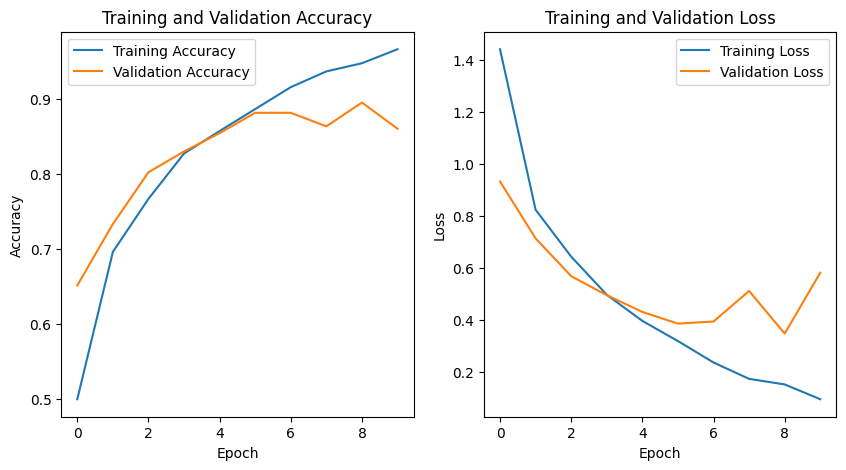

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.show()


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.6),  # Rotate images by up to 20%
    layers.RandomZoom(0.4)       # Zoom in or out by up to 20%
])

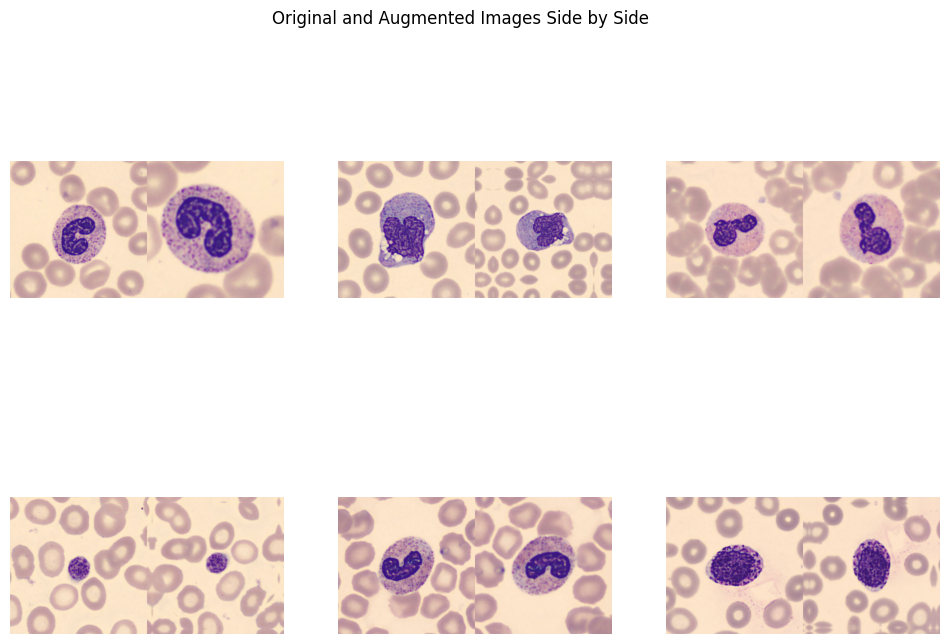

In [ ]:
# Function to plot images in a grid
def plot_images_side_by_side(original_images, augmented_images, title):
    plt.figure(figsize=(12, 8))  # Adjusted figure size for 6 images
    for i in range(min(6, len(original_images))):  # Plot up to 6 pairs of images
        # Concatenate original and augmented images horizontally
        combined_image = np.hstack((original_images[i], augmented_images[i]))

        plt.subplot(2, 3, i + 1)  # Adjusted layout to 2 rows, 3 columns
        plt.imshow(combined_image.astype("uint8"))  # Convert to uint8 for display
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Get a batch of images from the training dataset (assuming you have a dataset ready)
for images, _ in train_ds.take(1):  # Take a single batch of images from the dataset
    # Convert original images to [0, 255] range if they are normalized
    original_images = images.numpy() * 255.0
    original_images = original_images.astype("uint8")

    # Apply data augmentation to a copy of the images and convert to displayable format
    augmented_images = data_augmentation(tf.identity(images), training=True).numpy() * 255.0
    augmented_images = augmented_images.astype("uint8")

    # Plot original and augmented images side by side
    plot_images_side_by_side(original_images, augmented_images, title="Original and Augmented Images Side by Side")

In [ ]:

def create_augmented_cnn_model(input_shape):
    model = models.Sequential([
        data_augmentation,  # Include data augmentation in the model
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(8, activation='softmax')  # Assuming 8 classes
    ])
    return model

# Instantiate the model with data augmentation
augmented_model = create_augmented_cnn_model((256, 256, 3))

# Compile the model with the correct metrics
augmented_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the model architecture
def create_augmented_cnn_model(input_shape):
    model = models.Sequential([
        data_augmentation,  # Include data augmentation in the model
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(8, activation='softmax')  # Assuming 8 classes
    ])
    return model

# Instantiate the model with data augmentation
augmented_model = create_augmented_cnn_model((256, 256, 3))

# Compile the model with the correct metrics
augmented_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

# Set up EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy', 'val_auc', etc.
    patience=3,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)


In [ ]:
# Train the model with EarlyStopping
history_augmented = augmented_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=25,  # You can set this higher, training may stop earlier due to early stopping
    callbacks=[early_stopping]  # Include early stopping in the callbacks list
)

Epoch 1/25
321/321 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.3810 - auc: 0.7793 - loss: 1.7808 - precision: 0.5799 - recall: 0.1575 - val_accuracy: 0.7044 - val_auc: 0.9619 - val_loss: 0.7406 - val_precision: 0.8869 - val_recall: 0.5590
Epoch 2/25
321/321 ━━━━━━━━━━━━━━━━━━━━ 28s 87ms/step - accuracy: 0.7364 - auc: 0.9609 - loss: 0.7339 - precision: 0.8367 - recall: 0.6301 - val_accuracy: 0.8186 - val_auc: 0.9803 - val_loss: 0.5147 - val_precision: 0.8768 - val_recall: 0.7626
Epoch 3/25
321/321 ━━━━━━━━━━━━━━━━━━━━ 28s 87ms/step - accuracy: 0.8162 - auc: 0.9796 - loss: 0.5152 - precision: 0.8615 - recall: 0.7671 - val_accuracy: 0.8084 - val_auc: 0.9795 - val_loss: 0.5235 - val_precision: 0.8499 - val_recall: 0.7807
Epoch 4/25
321/321 ━━━━━━━━━━━━━━━━━━━━ 28s 87ms/step - accuracy: 0.8444 - auc: 0.9836 - loss: 0.4530 - precision: 0.8810 - recall: 0.8084 - val_accuracy: 0.8963 - val_auc: 0.9916 - val_loss: 0.3097 - val_precision: 0.9092 - val_recall: 0.8803
Epoch 5/25
321/321 ━━━━━

In [ ]:
history_augmented = augmented_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10  # Adjust the number of epochs as necessary
)


Epoch 1/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.4522 - auc: 0.8226 - loss: 1.8018 - precision: 0.6471 - recall: 0.2294 - val_accuracy: 0.7424 - val_auc: 0.9641 - val_loss: 0.7149 - val_precision: 0.7726 - val_recall: 0.6928
Epoch 2/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.7789 - auc: 0.9719 - loss: 0.6141 - precision: 0.8399 - recall: 0.7098 - val_accuracy: 0.8490 - val_auc: 0.9850 - val_loss: 0.4352 - val_precision: 0.8805 - val_recall: 0.8137
Epoch 3/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.8552 - auc: 0.9840 - loss: 0.4482 - precision: 0.8832 - recall: 0.8165 - val_accuracy: 0.8841 - val_auc: 0.9891 - val_loss: 0.3631 - val_precision: 0.9081 - val_recall: 0.8572
Epoch 4/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 28s 86ms/step - accuracy: 0.8737 - auc: 0.9880 - loss: 0.3725 - precision: 0.8953 - recall: 0.8500 - val_accuracy: 0.8957 - val_auc: 0.9902 - val_loss: 0.3159 - val_precision: 0.9027 - val_recall: 0.8838
Epoch 5/10
321/321 ━━━━━

In [ ]:
# Evaluate on validation data
val_results_augmented = augmented_model.evaluate(validation_ds)
print(f"Validation Loss (Augmented): {val_results_augmented[0]}")
print(f"Validation Accuracy (Augmented): {val_results_augmented[1]}")
print(f"Validation Recall (Augmented): {val_results_augmented[2]}")
print(f"Validation Precision (Augmented): {val_results_augmented[3]}")
print(f"Validation AUC (Augmented): {val_results_augmented[4]}")

# Evaluate on test data
test_results_augmented = augmented_model.evaluate(test_ds)
print(f"Test Loss (Augmented): {test_results_augmented[0]}")
print(f"Test Accuracy (Augmented): {test_results_augmented[1]}")
print(f"Test Recall (Augmented): {test_results_augmented[2]}")
print(f"Test Precision (Augmented): {test_results_augmented[3]}")
print(f"Test AUC (Augmented): {test_results_augmented[4]}")


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8935 - auc: 0.9919 - loss: 0.3054 - precision: 0.9073 - recall: 0.8782
Validation Loss (Augmented): 0.3095270097255707
Validation Accuracy (Augmented): 0.8945677280426025
Validation Recall (Augmented): 0.9067873358726501
Validation Precision (Augmented): 0.8779205679893494
Validation AUC (Augmented): 0.9916324615478516
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.8970 - auc: 0.9930 - loss: 0.2824 - precision: 0.9103 - recall: 0.8837
Test Loss (Augmented): 0.3021998107433319
Test Accuracy (Augmented): 0.8925644159317017
Test Recall (Augmented): 0.9078549742698669
Test Precision (Augmented): 0.8796838521957397
Test AUC (Augmented): 0.991680920124054


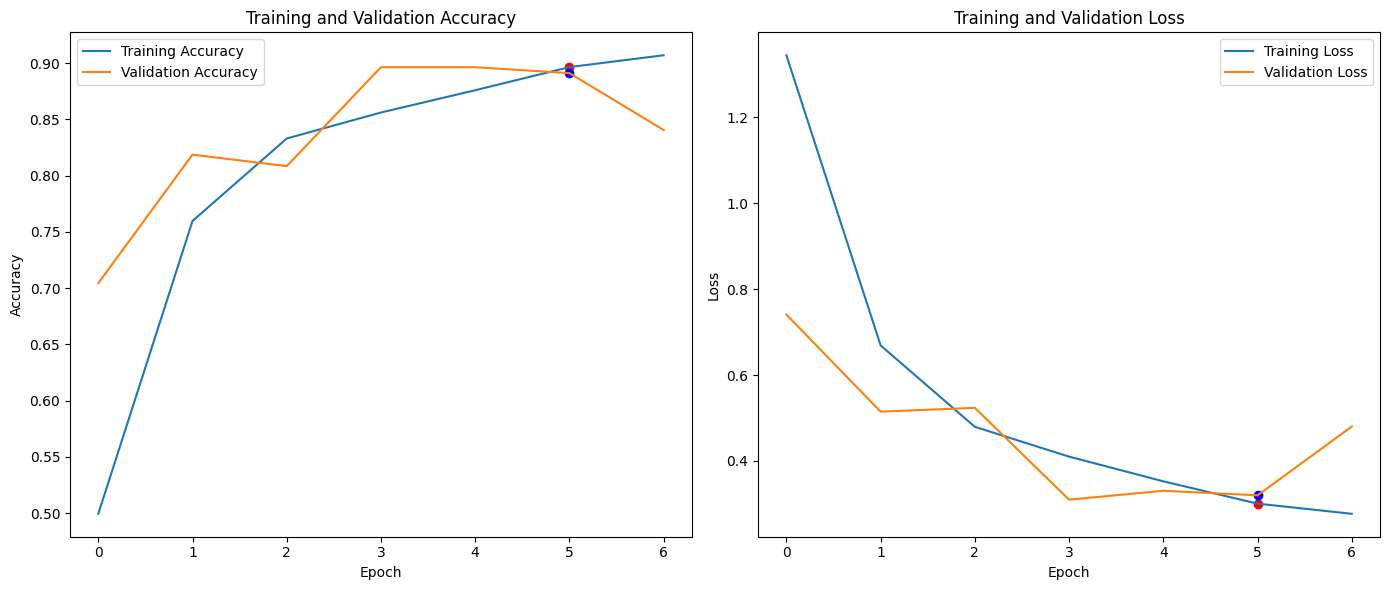

In [ ]:
# Function to find the closest convergence point between training and validation curves
def find_convergence_point(training, validation):
    differences = np.abs(np.array(training) - np.array(validation))
    min_index = np.argmin(differences)
    return min_index, training[min_index], validation[min_index]

# Plotting the training and validation accuracy and loss

plt.figure(figsize=(14, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_augmented.history['accuracy'], label='Training Accuracy')
plt.plot(history_augmented.history['val_accuracy'], label='Validation Accuracy')

# Find and plot convergence point for accuracy
conv_index, train_acc_conv, val_acc_conv = find_convergence_point(
    history_augmented.history['accuracy'],
    history_augmented.history['val_accuracy']
)
plt.scatter(conv_index, train_acc_conv, color='red')
plt.scatter(conv_index, val_acc_conv, color='blue')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_augmented.history['loss'], label='Training Loss')
plt.plot(history_augmented.history['val_loss'], label='Validation Loss')

# Find and plot convergence point for loss
conv_index, train_loss_conv, val_loss_conv = find_convergence_point(
    history_augmented.history['loss'],
    history_augmented.history['val_loss']
)
plt.scatter(conv_index, train_loss_conv, color='red')
plt.scatter(conv_index, val_loss_conv, color='blue')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# Initial split: 60% training, 40% for testing+validation
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4, random_state=42)

# Second split of the remaining data into testing and validation: 50% each of the remaining 40% data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')
print(f'Test data shape: {X_test.shape}')

Training data shape: (10261, 128, 128, 3)
Validation data shape: (3420, 128, 128, 3)
Test data shape: (3421, 128, 128, 3)


In [ ]:
# Flatten the image data for models , 1D feature vectors per sample
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

In [ ]:
# Train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_flat, y_train)

# Predict on the test data
y_pred_test = rf.predict(X_test_flat)

# Evaluate the Random Forest model on Test Data
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Random Forest Test Accuracy:", accuracy_test)
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

# Predict on the validation data
y_pred_val = rf.predict(X_val_flat)

# Evaluate the Random Forest model on Validation Data
accuracy_val = accuracy_score(y_val, y_pred_val)
print("Random Forest Validation Accuracy:", accuracy_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_pred_val))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val))

Random Forest Test Accuracy: 0.842443729903537
Test Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.54      0.65       221
           1       0.90      0.82      0.86       323
           2       0.62      0.82      0.70       549
           3       0.79      0.77      0.78       243
           4       1.00      0.99      0.99       482
           5       0.87      0.49      0.63       306
           6       0.87      0.94      0.90       667
           7       0.94      0.96      0.95       630

    accuracy                           0.84      3421
   macro avg       0.85      0.79      0.81      3421
weighted avg       0.85      0.84      0.84      3421

Test Confusion Matrix:
[[120   1  55  23   0   3   5  14]
 [  3 264  32  10   0   0  14   0]
 [ 10   6 451  11   0  18  49   4]
 [  3  12  36 187   0   0   5   0]
 [  0   1   0   0 479   0   2   0]
 [  8   0 135   1   0 151   8   3]
 [  0   7  13   3   0   1 627  16]
 [  2 

In [ ]:
# Train the Support Vector Machine Classifier
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_flat, y_train)

# Predict on the test data
y_pred_test = svm.predict(X_test_flat)

# Evaluate the SVM on Test Data
accuracy_test = accuracy_score(y_test, y_pred_test)
print("SVM Test Accuracy:", accuracy_test)
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

# Predict on the validation data
y_pred_val = svm.predict(X_val_flat)

# Evaluate the SVM on Validation Data
accuracy_val = accuracy_score(y_val, y_pred_val)
print("SVM Validation Accuracy:", accuracy_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_pred_val))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val))

SVM Test Accuracy: 0.8099970768781058
Test Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.66      0.59       221
           1       0.87      0.85      0.86       323
           2       0.58      0.64      0.61       549
           3       0.80      0.73      0.76       243
           4       0.99      0.99      0.99       482
           5       0.70      0.60      0.65       306
           6       0.90      0.86      0.88       667
           7       0.95      0.92      0.94       630

    accuracy                           0.81      3421
   macro avg       0.79      0.78      0.78      3421
weighted avg       0.82      0.81      0.81      3421

Test Confusion Matrix:
[[145   0  62  10   0   2   2   0]
 [  6 276  12  15   4   3   7   0]
 [ 76   8 354  11   0  69  28   3]
 [  8  20  36 177   0   0   2   0]
 [  0   4   0   0 477   0   1   0]
 [ 17   3  97   2   0 184   2   1]
 [  7   8  44   4   0   3 576  25]
 [ 10   0   7  

In [ ]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=100)  # Number of components to keep
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)
X_val_pca = pca.transform(X_val_flat)  # Transform validation data

# Train Gradient Boosting on the PCA-reduced dataset
gb_pca = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_pca.fit(X_train_pca, y_train)

# Predict on the test data
y_pred_test_gb_pca = gb_pca.predict(X_test_pca)

# Evaluate on Test Data
accuracy_test_gb_pca = accuracy_score(y_test, y_pred_test_gb_pca)
print("Gradient Boosting with PCA Test Accuracy:", accuracy_test_gb_pca)
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test_gb_pca))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test_gb_pca))

# Predict on the validation data
y_pred_val_gb_pca = gb_pca.predict(X_val_pca)

# Evaluate on Validation Data
accuracy_val_gb_pca = accuracy_score(y_val, y_pred_val_gb_pca)
print("Gradient Boosting with PCA Validation Accuracy:", accuracy_val_gb_pca)
print("Validation Classification Report:")
print(classification_report(y_val, y_pred_val_gb_pca))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val_gb_pca))

Gradient Boosting with PCA Test Accuracy: 0.7214264834843613
Test Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.53      0.56       221
           1       0.76      0.71      0.73       323
           2       0.60      0.58      0.59       549
           3       0.71      0.67      0.69       243
           4       0.97      0.99      0.98       482
           5       0.58      0.48      0.53       306
           6       0.76      0.82      0.79       667
           7       0.68      0.74      0.71       630

    accuracy                           0.72      3421
   macro avg       0.71      0.69      0.70      3421
weighted avg       0.72      0.72      0.72      3421

Test Confusion Matrix:
[[118   2  47  17   0  17   1  19]
 [ 16 230  16  23  15   1  21   1]
 [ 26  12 316  18   0  49  64  64]
 [  8  28  17 164   0   0  18   8]
 [  0   7   0   0 475   0   0   0]
 [ 28   0  67   0   0 147  10  54]
 [  0  16  14   6   0   6 5

In [ ]:
def evaluate_model(model, X, y, data_type="Test"):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    clf_report = classification_report(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)

    print(f"Evaluating  on {data_type} Data")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(clf_report)
    print("Confusion Matrix:")
    print(conf_matrix)

In [ ]:
import joblib
# Setup the GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train_flat, y_train)

# Best parameters and score
print("Best parameters:", grid_search_rf.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_rf.best_score_))

# Evaluate on the test data
print("Evaluating Random Forest on Test Data")
evaluate_model(grid_search_rf.best_estimator_, X_test_flat, y_test)

# Evaluate on the validation data
print("Evaluating Random Forest on Validation Data")
evaluate_model(grid_search_rf.best_estimator_, X_val_flat, y_val)




Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation score: 0.85
Evaluating Random Forest on Test Data
Evaluating  on Test Data
Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.52      0.66       221
           1       0.92      0.80      0.86       323
           2       0.62      0.85      0.72       549
           3       0.76      0.77      0.76       243
           4       1.00      0.99      0.99       482
           5       0.89      0.50      0.64       306
           6       0.88      0.95      0.91       667
           7       0.95      0.96      0.96       630

    accuracy                           0.85      3421
   macro avg       0.86      0.79      0.81      3421
weighted avg       0.86      0.85      0.84      3421

Confusion Matrix:
[[115   1  64  26   0   1   3  11]
 [  3 260  31  14   0   0  15   0]
 [  3   2 465  14   0

In [ ]:
# Save the best model to Google Drive
joblib.dump(grid_search_rf.best_estimator_, '/content/drive/My Drive/best_random_forest_model.pkl')
print("Model saved to Google Drive: /content/drive/My Drive/best_random_forest_model.pkl")

Model saved to Google Drive: /content/drive/My Drive/best_random_forest_model.pkl


In [ ]:
import joblib
# Load the model from Google Drive
loaded_model = joblib.load('/content/drive/My Drive/best_random_forest_model.pkl')
print("Model loaded from /content/drive/My Drive/best_random_forest_model.pkl")

# Evaluate on the test data
print("Evaluating Random Forest on Test Data")
evaluate_model(loaded_model, X_test_flat, y_test)

# Evaluate on the validation data
print("Evaluating Random Forest on Validation Data")
evaluate_model(loaded_model, X_val_flat, y_val)

Model loaded from /content/drive/My Drive/best_random_forest_model.pkl
Evaluating Random Forest on Test Data
Evaluating  on Test Data
Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.52      0.66       221
           1       0.92      0.80      0.86       323
           2       0.62      0.85      0.72       549
           3       0.76      0.77      0.76       243
           4       1.00      0.99      0.99       482
           5       0.89      0.50      0.64       306
           6       0.88      0.95      0.91       667
           7       0.95      0.96      0.96       630

    accuracy                           0.85      3421
   macro avg       0.86      0.79      0.81      3421
weighted avg       0.86      0.85      0.84      3421

Confusion Matrix:
[[115   1  64  26   0   1   3  11]
 [  3 260  31  14   0   0  15   0]
 [  3   2 465  14   0  17  45   3]
 [  2  11  36 187   0   0   7   0]
 [  0   2   0   0 4

In [ ]:
# Setup the GridSearchCV for SVM
param_grid_svm = {
    'C': [10],  # Regularization parameter
    'gamma': ['scale'],  # Kernel coefficient
    'kernel': ['rbf'],  # Specifies the kernel type to be used in the algorithm
    'probability': [True]  # Wrap the boolean in a list
}
svm = SVC(random_state=42)
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=3, n_jobs=-1, verbose=2)
grid_search_svm.fit(X_train_flat, y_train)

# Output best parameters and cross-validation score
print("Best parameters:", grid_search_svm.best_params_)
print(f"Best cross-validation score: {grid_search_svm.best_score_:.2f}")

# Assuming evaluate_model is a function you have defined:
# Evaluate on the test data
evaluate_model(grid_search_svm.best_estimator_, X_test_flat, y_test, "Test")

# Evaluate on the validation data
evaluate_model(grid_search_svm.best_estimator_, X_val_flat, y_val, "Validation")



Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}
Best cross-validation score: 0.85
Evaluating  on Test Data
Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       221
           1       0.88      0.82      0.85       323
           2       0.66      0.76      0.71       549
           3       0.80      0.76      0.78       243
           4       0.99      0.99      0.99       482
           5       0.82      0.68      0.74       306
           6       0.90      0.92      0.91       667
           7       0.96      0.94      0.95       630

    accuracy                           0.85      3421
   macro avg       0.84      0.82      0.83      3421
weighted avg       0.86      0.85      0.85      3421

Confusion Matrix:
[[152   2  49  13   0   5   0   0]
 [  5 265  19  13   5   3  13   0]
 [ 42   6 417  14   0  35  32   3]
 [  7  12  35 185   0   0   4   0]
 [  0   4  

In [ ]:
# Save the best model to Google Drive
joblib.dump(grid_search_svm.best_estimator_, '/content/drive/My Drive/best_svm_model.pkl')
print("Model saved to Google Drive: /content/drive/My Drive/best_svm_model.pkl")

Model saved to Google Drive: /content/drive/My Drive/best_svm_model.pkl


In [ ]:
# Load the model from Google Drive
loaded_svm_model = joblib.load('/content/drive/My Drive/best_svm_model.pkl')
print("Model loaded from /content/drive/My Drive/best_svm_model.pkl")

Model loaded from /content/drive/My Drive/best_svm_model.pkl


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Generate meta-features for training set using cross-validated predictions
rf_meta_features = cross_val_predict(grid_search_rf.best_estimator_, X_train_flat, y_train, cv=3, method='predict_proba')
svm_meta_features = cross_val_predict(grid_search_svm.best_estimator_, X_train_flat, y_train, cv=3, method='predict_proba')

# Stack the training meta-features
X_meta_train = np.hstack((rf_meta_features, svm_meta_features))

# Generate and stack meta-features for the test set
rf_test_meta = grid_search_rf.best_estimator_.predict_proba(X_test_flat)
svm_test_meta = grid_search_svm.best_estimator_.predict_proba(X_test_flat)
X_meta_test = np.hstack((rf_test_meta, svm_test_meta))

# Generate and stack meta-features for the validation set
rf_val_meta = grid_search_rf.best_estimator_.predict_proba(X_val_flat)
svm_val_meta = grid_search_svm.best_estimator_.predict_proba(X_val_flat)
X_meta_val = np.hstack((rf_val_meta, svm_val_meta))

# Create a meta-model with Logistic Regression
meta_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
meta_model.fit(X_meta_train, y_train)

# Evaluate the meta-model on the test data
test_predictions = meta_model.predict(X_meta_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Stacking Model Test Accuracy: {test_accuracy:.4f}")

# Evaluate the meta-model on the validation data
val_predictions = meta_model.predict(X_meta_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Stacking Model Validation Accuracy: {val_accuracy:.4f}")

# Detailed performance metrics for test data
print("Test Data Classification Report:")
print(classification_report(y_test, test_predictions))

# Detailed performance metrics for validation data
print("Validation Data Classification Report:")
print(classification_report(y_val, val_predictions))

# Confusion Matrix for test data
print("Test Data Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

# Confusion Matrix for validation data
print("Validation Data Confusion Matrix:")
print(confusion_matrix(y_val, val_predictions))

Stacking Model Test Accuracy: 0.8869
Stacking Model Validation Accuracy: 0.8924
Test Data Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       221
           1       0.91      0.86      0.89       323
           2       0.72      0.80      0.76       549
           3       0.84      0.78      0.81       243
           4       1.00      0.99      1.00       482
           5       0.84      0.71      0.77       306
           6       0.93      0.94      0.94       667
           7       0.97      0.97      0.97       630

    accuracy                           0.89      3421
   macro avg       0.88      0.87      0.87      3421
weighted avg       0.89      0.89      0.89      3421

Validation Data Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       262
           1       0.91      0.87      0.89       294
           2       0.76      0.83 

In [5]:
import pandas as pd
import seaborn as sns
# Store the performance metrics in a pandas DataFrame
data = {
    'Model': [
        'Random Forest',
        'SVM',
        'Gradient Boosting',
        'Random Forest (Hyper-parameterized)',
        'SVM (Hyper-parameterized)',
        'CNN (Without Augmentation)',
        'CNN (With Augmentation)',
        'Ensemble'
    ],
    'Accuracy': [
        0.84, 0.81, 0.72, 0.85, 0.85, 0.8627, 0.8844, 0.89
    ],
    'Recall': [
        0.79, 0.78, 0.69, 0.79, 0.82, 0.8580, 0.8691, 0.87
    ]
}

df = pd.DataFrame(data)


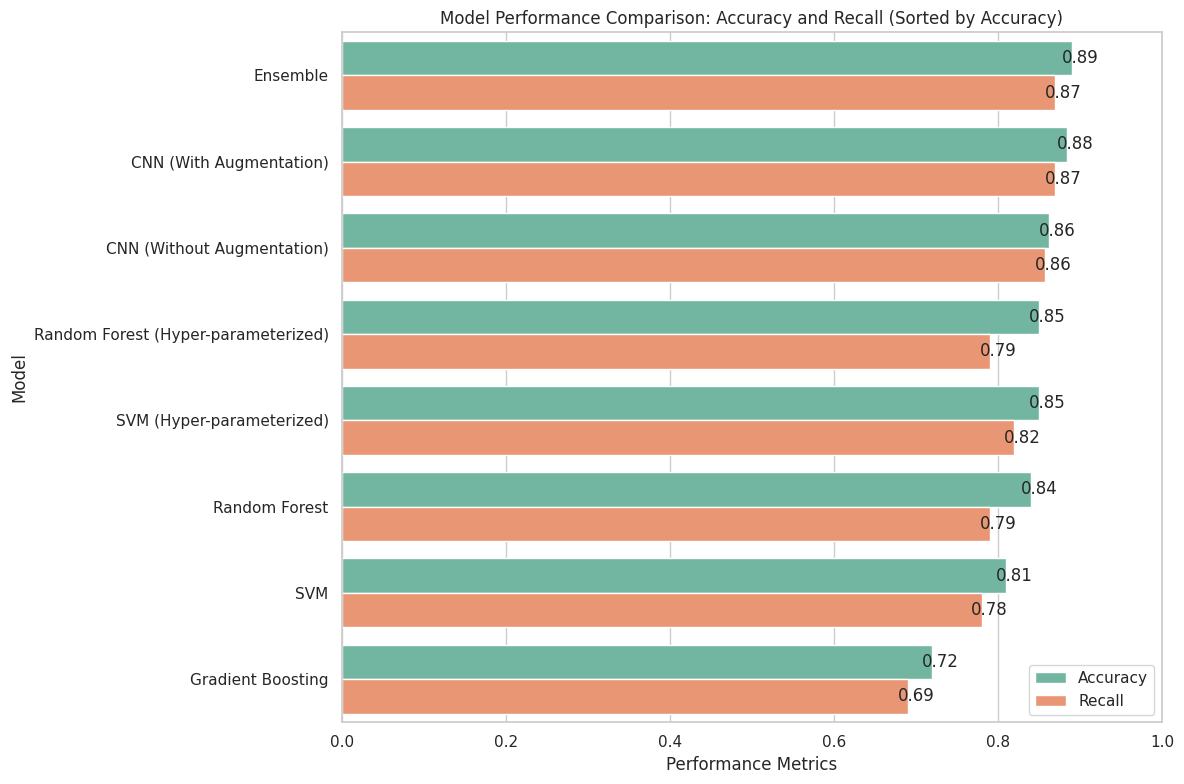

In [10]:
# Sort the DataFrame by Accuracy in descending order
df_sorted = df.sort_values(by='Accuracy', ascending=False)

# Melt the sorted dataframe to long format for seaborn
df_melted_sorted = df_sorted.melt(id_vars='Model', value_vars=['Accuracy', 'Recall'], var_name='Metric', value_name='Value')

# Set the plot style and size
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Create a grouped bar plot with the sorted data
bar_plot = sns.barplot(x='Value', y='Model', hue='Metric', data=df_melted_sorted, palette='Set2')

# Add value annotations to the bars, placing accuracy and recall on their respective bars
for i in range(len(df_melted_sorted)):
    value = df_melted_sorted['Value'][i]
    metric = df_melted_sorted['Metric'][i]
    model = df_melted_sorted['Model'][i]

    # Get the bar's coordinates
    y = bar_plot.patches[i].get_y() + bar_plot.patches[i].get_height() / 2
    x = bar_plot.patches[i].get_width()

    # Annotate the bar with its corresponding value
    plt.text(x + 0.01, y, f'{value:.2f}', ha='center', va='center')

# Add labels and title
plt.xlabel('Performance Metrics')
plt.ylabel('Model')
plt.title('Model Performance Comparison: Accuracy and Recall (Sorted by Accuracy)')
plt.xlim(0, 1)  # Limit x-axis to range [0, 1]
plt.legend(loc='lower right')

# Show plot
plt.tight_layout()
plt.show()